# ADA Project : Milestone 2

## Cracking the Hollywood interview

On average, the production of a major box office movie costs $65 million, without counting the marketing and distribution fees. Unlike house construction, which usually ends up exactly like the pre-sketched plan, making a movie is unpredictable and anticipating the audience’s opinion is nearly impossible despite the effort and money spent.
Thus, producing it the right way is a crucial job that requires long-time studies and decision-making about the relevant parts that define the movie. This includes the storyline, the script, the actors, the budget, and many more.
This motivates our goal of studying the successful as well as failed films in terms of public ratings collected through the IMDB databases as well as the box office revenue. We mainly analyze the different metrics that define a movie in order to come up with a set of criteria that, if present, will more likely make it successful.

### 1) Imports

In [2]:
import os
import math
import json
import nltk
import gzip
import pickle
import requests
import xmltodict

import numpy as np
import pandas as pd
import seaborn as sns

import scipy.stats as stats
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from __future__ import annotations

from zipfile import ZipFile
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

### 2) Utility functions

Some basic functions that may be helpful later.

In [2]:
def freebase_to_wiki_id(freebase_id: str) -> str | None:
    """
    Query Wikidata ID from Freebase ID
    :param freebase_id: str
    :return: corresponding wiki ID
    """
    url = f"https://www.wikidata.org/w/index.php?search={freebase_id}&title=Special%3ASearch&go=Go"
    res = BeautifulSoup(requests.get(url).text, "html.parser")\
        .find("div", {"class": "mw-search-result-heading"})
    if res is not None:
        return res.find("a")["href"].split("/")[-1]
    return None

path_corenlp = '../data/corenlp_plot_summaries/'

def parse_summaries(file: str) -> BeautifulSoup:
    """
    Parse XML npl processed summary
    :param file: name of
    :return: BeautifulSoup object
    """
    with gzip.open(path_corenlp + file, 'rb') as f:
        data = f.read()
    return BeautifulSoup(data, features="xml")

### 3) Movie metadata analysis and processing

We start by analyzing and cleaning the movies' metadata file ``movie.metadata.tsv``.

#### 3.1) Getting more revenue data

In [3]:
# Load the dataset
metadata_df = pd.read_csv('data/movie.metadata.tsv', sep="\t")
metadata_df

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples)
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


In [4]:
# Get some insights
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Wikipedia movie ID                         81741 non-null  int64  
 1   Freebase movie ID                          81741 non-null  object 
 2   Movie name                                 81741 non-null  object 
 3   Movie release date                         74839 non-null  object 
 4   Movie box office revenue                   8401 non-null   float64
 5   Movie runtime                              61291 non-null  float64
 6   Movie languages                            81741 non-null  object 
 7   Movie countries (Freebase ID:name tuples)  81741 non-null  object 
 8   Movie genres (Freebase ID:name tuples)     81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


Since the revenue is an important feature in our study, let's see if we have enough data:

In [5]:
metadata_df['Movie box office revenue'].isna().sum() / metadata_df.shape[0] * 100

89.72241592346558

Around 90% of the movie revenues are absent. We used the ``boxoffice.csv`` dataset to enrich our dataset:

In [6]:
def extract_release_year(df):
    """
    Exctracts the release year from the release date as a new column
    :param df: the dataframe
    :return: The extended dataframe
    """
    df['Movie release year'] = df['Movie release date'].astype(str).str[:4]
    df = df[df["Movie release year"].str.contains("nan") == False].copy()
    df['Movie release year'] = df['Movie release year'].apply(lambda x: int(x))
    return df

In [7]:
# Add a release year column for convenience
metadata_df = extract_release_year(metadata_df)

In [8]:
# Load the revenue dataset
revenue = pd.read_csv('data/boxoffice.csv', sep=',')

In [9]:
# Fill some of the absent revenue fields from the boxoffice dataset
metadata_df.set_index(['Movie name','Movie release year'])
revenue.set_index(['title','year'])
metadata_df['Movie box office revenue'].fillna(revenue['lifetime_gross'], inplace=True)

In [10]:
metadata_df['Movie box office revenue'].isna().sum() / metadata_df.shape[0] * 100

71.77808361950319

We gained around 20% of relevant data!

#### 3.2) Additional data on movies' ratings

We add information about movie's ratings thanks to the IMDb dataset.
The IMDb dataset is described at <https://www.imdb.com/interfaces/> , which is a version granted by IMDb for academic purposes. We have asked and being authorised by the IMDb team to have access to it.

The following gets IMDb movies' ratings from ``imdb_title_ratings.tsv``.

**IMDb ratings dataset:**

- **tconst**: unique identifier of the movie
- **averageRating**: average of user ratings
- **numVotes**: number of ratings submitted for the movie

In [11]:
# IMDb ratings dataset
imdb_ratings_df = pd.read_csv('data/imdb_title_ratings.tsv', sep='	')
imdb_ratings_df.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1924
1,tt0000002,5.8,260
2,tt0000003,6.5,1733
3,tt0000004,5.6,174
4,tt0000005,6.2,2545


**IMDb videos' metadata dataset:**

- **tconst**: unique identifier of title
- **titleType**: type of the title (movie, TV series, etc.)
- **primaryTitle**: title the film is known for
    - **originalTitle**: original title (in original language) of film
- **isAdult**: indicator about adult category
- **startYear**: release year
- **endYear**: end year (for series)
- **runtimeMinutes**: duration of the title in minutes
- **genres**: up to three genres associated to the title

In [12]:
# IMDb videos' metadata dataset
imdb_names_df = pd.read_csv('data/imdb_title_basics.tsv', sep='	', low_memory=False)
# Only keep audiovisual products labeled as movies
imdb_names_df = imdb_names_df[imdb_names_df['titleType'] == 'movie']
imdb_names_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
610,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama


In [13]:
# Join between IMDb movies' rating and metadata
imdb_ratings_meta = imdb_ratings_df.merge(imdb_names_df, on='tconst', how='inner')
imdb_ratings_meta.head()

,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000009,5.2,200,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
1,tt0000502,4.2,14,movie,Bohemios,Bohemios,0,1905,\N,100,\N
2,tt0000574,6.0,794,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
3,tt0000591,5.1,20,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
4,tt0000615,4.3,23,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama


We merge the original CMU dataset with the IMDb dataset.

In [14]:
# Join between CMU and IMDb datasets
ratings_merge = metadata_df.merge(imdb_ratings_meta, left_on='Movie name', right_on = 'primaryTitle', how='inner')
ratings_merge.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),Movie release year,...,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,4.9,55229,movie,Ghosts of Mars,Ghosts of Mars,0,2001,\N,98,"Action,Horror,Sci-Fi"
1,28463795,/m/0crgdbh,Brun bitter,1988,700059566.0,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,...,5.7,40,movie,Brun bitter,Brun bitter,0,1988,\N,83,"Crime,Drama"
2,261236,/m/01mrr1,A Woman in Flames,1983,659363944.0,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,...,6.0,589,movie,A Woman in Flames,Die flambierte Frau,0,1983,\N,106,Drama
3,13696889,/m/03cfc81,The Gangsters,1913-05-29,652270625.0,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,...,5.7,31,movie,The Gangsters,Les truands,0,1957,\N,105,"Comedy,Crime"
4,23070193,/m/064mmt5,The Gangsters,1956,NaN,NaN,"{""/m/064_8sq"": ""French Language""}","{""/m/0f8l9c"": ""France""}","{""/m/05p553"": ""Comedy film""}",1956,...,5.7,31,movie,The Gangsters,Les truands,0,1957,\N,105,"Comedy,Crime"


We clean the joined datasets by keeping entries that are consistent in their release dates. In other words, release year has to be similar in both datasets, otherwise we consider an entry may contain erroneous or noisy data and we discard it.

In [15]:
# Format movie release date
ratings_merge = extract_release_year(ratings_merge)

In [16]:
# Filter pairs (obtained by join) by almost same release year (max. difference of two)
ratings_merge = ratings_merge[ratings_merge['startYear'] != '\\N']
ratings_merge['releaseDiff'] = (ratings_merge['Movie release year'].astype(int) - ratings_merge['startYear'].astype(int)).abs()
ratings_merge = ratings_merge[ratings_merge['releaseDiff'] <= 2]

We also clean the joined datasets with respect to the movie's runtime.

In [17]:
# Filter pairs (obtained by join) by almost same runtime (max. difference of 10% with respect of the CMU duration)
# First, we handle the problem of non-existing runtime information for some entries
ratings_merge = ratings_merge[ratings_merge['runtimeMinutes'] != '\\N']
ratings_merge['Movie runtime'].fillna(-1, inplace=True)

ratings_merge['runtimeDiff'] = (ratings_merge['Movie runtime'].astype(int) - ratings_merge['runtimeMinutes'].astype(int)).abs()
ratings_merge = ratings_merge[ratings_merge['runtimeDiff'] <= ratings_merge['Movie runtime']/10]

In [18]:
ratings_merge.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),Movie release year,...,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,releaseDiff,runtimeDiff
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,movie,Ghosts of Mars,Ghosts of Mars,0,2001,\N,98,"Action,Horror,Sci-Fi",0,0
1,28463795,/m/0crgdbh,Brun bitter,1988,700059566.0,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,...,movie,Brun bitter,Brun bitter,0,1988,\N,83,"Crime,Drama",0,0
2,261236,/m/01mrr1,A Woman in Flames,1983,659363944.0,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,...,movie,A Woman in Flames,Die flambierte Frau,0,1983,\N,106,Drama,0,0
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,623357910.0,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...",2002,...,movie,The Sorcerer's Apprentice,The Sorcerer's Apprentice,0,2001,\N,86,"Adventure,Family,Fantasy",1,0
13,12621957,/m/05pdd86,The Sorcerer's Apprentice,2010-07-08,215283742.0,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...",2010,...,movie,The Sorcerer's Apprentice,The Sorcerer's Apprentice,0,2010,\N,109,"Action,Adventure,Family",0,2


We clean the 'ratings_merge' dataframe (which is the result of joining IMDb's ratings and CMU datasets).
We remove duplicated or non-relevant columns and we order columns in more logical order (with adjacent columns containing similar information)

In [19]:
# Remove unnecessary columns
ratings_merge = ratings_merge.drop('releaseDiff', axis=1)
ratings_merge = ratings_merge.drop('runtimeDiff', axis=1)
ratings_merge = ratings_merge.drop('endYear', axis=1)
ratings_merge = ratings_merge.drop('Movie name', axis=1)
ratings_merge = ratings_merge.drop('Movie release date', axis=1)
ratings_merge = ratings_merge.drop('runtimeMinutes', axis=1)
ratings_merge = ratings_merge.drop('titleType', axis=1)

# Reorder columns
ratings_merge = ratings_merge[['Wikipedia movie ID', 'Freebase movie ID', 'tconst', 'primaryTitle', 'originalTitle', 'Movie box office revenue', 'averageRating', 'numVotes', 'Movie runtime', 'Movie languages', 'Movie countries (Freebase ID:name tuples)', 'Movie genres (Freebase ID:name tuples)', 'genres', 'isAdult', 'startYear']]

In [20]:
ratings_merge.head()

,Wikipedia movie ID,Freebase movie ID,tconst,primaryTitle,originalTitle,Movie box office revenue,averageRating,numVotes,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),genres,isAdult,startYear
0,975900,/m/03vyhn,tt0228333,Ghosts of Mars,Ghosts of Mars,14010832.0,4.9,55229,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Action,Horror,Sci-Fi",0,2001
1,28463795,/m/0crgdbh,tt0094806,Brun bitter,Brun bitter,700059566.0,5.7,40,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","Crime,Drama",0,1988
2,261236,/m/01mrr1,tt0083949,A Woman in Flames,Die flambierte Frau,659363944.0,6.0,589,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",Drama,0,1983
6,18998739,/m/04jcqvw,tt0120166,The Sorcerer's Apprentice,The Sorcerer's Apprentice,623357910.0,4.2,605,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Adventure,Family,Fantasy",0,2001
13,12621957,/m/05pdd86,tt0963966,The Sorcerer's Apprentice,The Sorcerer's Apprentice,215283742.0,6.1,162916,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...","Action,Adventure,Family",0,2010


Now that 'ratings_merge' represent the an extended 'metadata_df' dataframe (with rating information and more consistent entries), we refer this 'ratings_merge' as the new 'metadata_df'.

In [21]:
# Assignment for extended dataframe
metadata_df = ratings_merge

# Useful labels for revenue and ratings
box_office_rev = 'Movie box office revenue'
box_office_rat = 'averageRating'

Now, we have a dataframe complete with non null revenues and ratings for sufficiently many movies, ready for use:

In [22]:
metadata_df = metadata_df[metadata_df[box_office_rev].notnull() & metadata_df[box_office_rat].notnull()].copy()
metadata_df

,Wikipedia movie ID,Freebase movie ID,tconst,primaryTitle,originalTitle,Movie box office revenue,averageRating,numVotes,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),genres,isAdult,startYear
0,975900,/m/03vyhn,tt0228333,Ghosts of Mars,Ghosts of Mars,14010832.0,4.9,55229,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Action,Horror,Sci-Fi",0,2001
1,28463795,/m/0crgdbh,tt0094806,Brun bitter,Brun bitter,700059566.0,5.7,40,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","Crime,Drama",0,1988
2,261236,/m/01mrr1,tt0083949,A Woman in Flames,Die flambierte Frau,659363944.0,6.0,589,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",Drama,0,1983
6,18998739,/m/04jcqvw,tt0120166,The Sorcerer's Apprentice,The Sorcerer's Apprentice,623357910.0,4.2,605,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Adventure,Family,Fantasy",0,2001
13,12621957,/m/05pdd86,tt0963966,The Sorcerer's Apprentice,The Sorcerer's Apprentice,215283742.0,6.1,162916,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...","Action,Adventure,Family",0,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86925,1191380,/m/04f_y7,tt0120514,Wilde,Wilde,2158775.0,6.9,17316,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...","Biography,Drama,Romance",0,1997
86926,54540,/m/0f7hw,tt0094898,Coming to America,Coming to America,288752301.0,7.1,208493,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...","Comedy,Romance",0,1988
86931,7761830,/m/0kvgqb,tt0100666,Spaced Invaders,Spaced Invaders,15369573.0,5.3,3738,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mt0"": ""Alien Film"", ""/m/06n90"": ""Scie...","Adventure,Comedy,Sci-Fi",0,1990
86936,1918494,/m/0660qx,tt0120202,State and Main,State and Main,6944471.0,6.7,21482,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/0gf28"": ""Parody"", ""/m/09n5t_"": ""Americana...","Comedy,Drama",0,2000


#### 3.3) Initial revenue and rating distributions

In this section, we examine basic facts and distributions of our data, starting with the global distribution of the revenue.

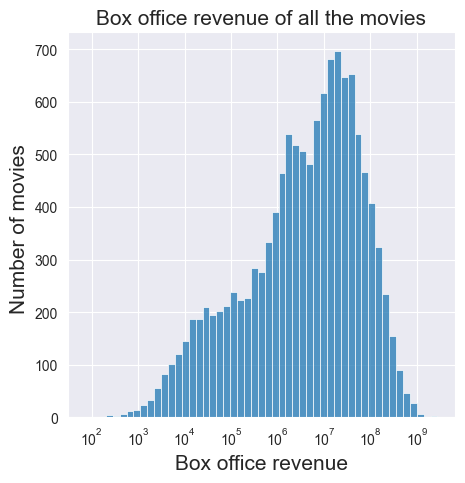

In [23]:
plt.figure(figsize=(5, 5))
plt.xlabel('Box office revenue', fontsize = 15)
plt.ylabel('Number of movies ', fontsize=15)
plt.title('Box office revenue of all the movies', fontsize=15)
sns.histplot(data=metadata_df[box_office_rev], log_scale=True)
plt.show()

Revenue seems to be slightly heavy tailed. Indeed:

In [24]:
metadata_df[box_office_rev].describe()

count    1.243500e+04
mean     3.528042e+07
std      9.060522e+07
min      7.200000e+01
25%      5.633580e+05
50%      5.656388e+06
75%      3.001691e+07
max      2.782275e+09
Name: Movie box office revenue, dtype: float64

The mean is 3.528042e+07, whilst the median is 5.656388e+06, an order of magnitude smaller.
Let's examine the ratings' distribution:

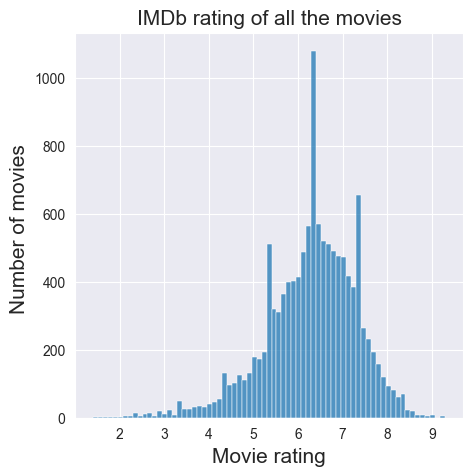

In [25]:
plt.figure(figsize=(5, 5))
plt.xlabel('Movie rating', fontsize = 15)
plt.ylabel('Number of movies ', fontsize=15)
plt.title('IMDb rating of all the movies', fontsize=15)
sns.histplot(data=metadata_df[box_office_rat])
plt.show()

This distribution seems closer to normal, with a few peaks.

In [26]:
metadata_df[box_office_rat].describe()

count    12435.000000
mean         6.288910
std          1.025507
min          1.400000
25%          5.700000
50%          6.400000
75%          7.000000
max          9.300000
Name: averageRating, dtype: float64

Median and mean are close. Is the distribution really approximately normal?

In [27]:
stats.normaltest(metadata_df[box_office_rat])

NormaltestResult(statistic=1130.8924137029335, pvalue=2.690497242564746e-246)

p-value is basically 0, we can confidently reject the hypothesis that the data comes from a normal distribution.

Let's have a quick look at the influence of the year when a movie was released on both rating and revenue.

In [28]:
sums_year = metadata_df.groupby('startYear')[[box_office_rev]].sum()[1:]
means_year = metadata_df.sort_values(by="startYear")

In [29]:
def plot_by_year(df: pd.Series | pd.DataFrame, prefix: str, metric: str, col: str, log_yscale=True):
    """
    Plot a year grouped column
    :param df: said column
    :param prefix: str
    :param metric: what is being plotted
    :param log_yscale: bool
    :param col: where to find data in df
    """
    fig, ax = plt.subplots()

    fig.set_size_inches(16, 8)
    ax.set_xlabel('Release year', fontsize=18)
    ax.set_ylabel(f'{prefix} {metric}', fontsize=16)
    ax.set_title(f'{prefix} {metric} by year', fontsize=16)
    ax.set_label("Floats")
    if prefix == "Mean":
        l = sns.lineplot(data=df, x="startYear", y=col, legend="brief")
    else:
        l = sns.lineplot(data=df, legend="brief")
    if log_yscale:
        l.set_yscale("log")
    plt.xticks(rotation=90)

    plt.show()

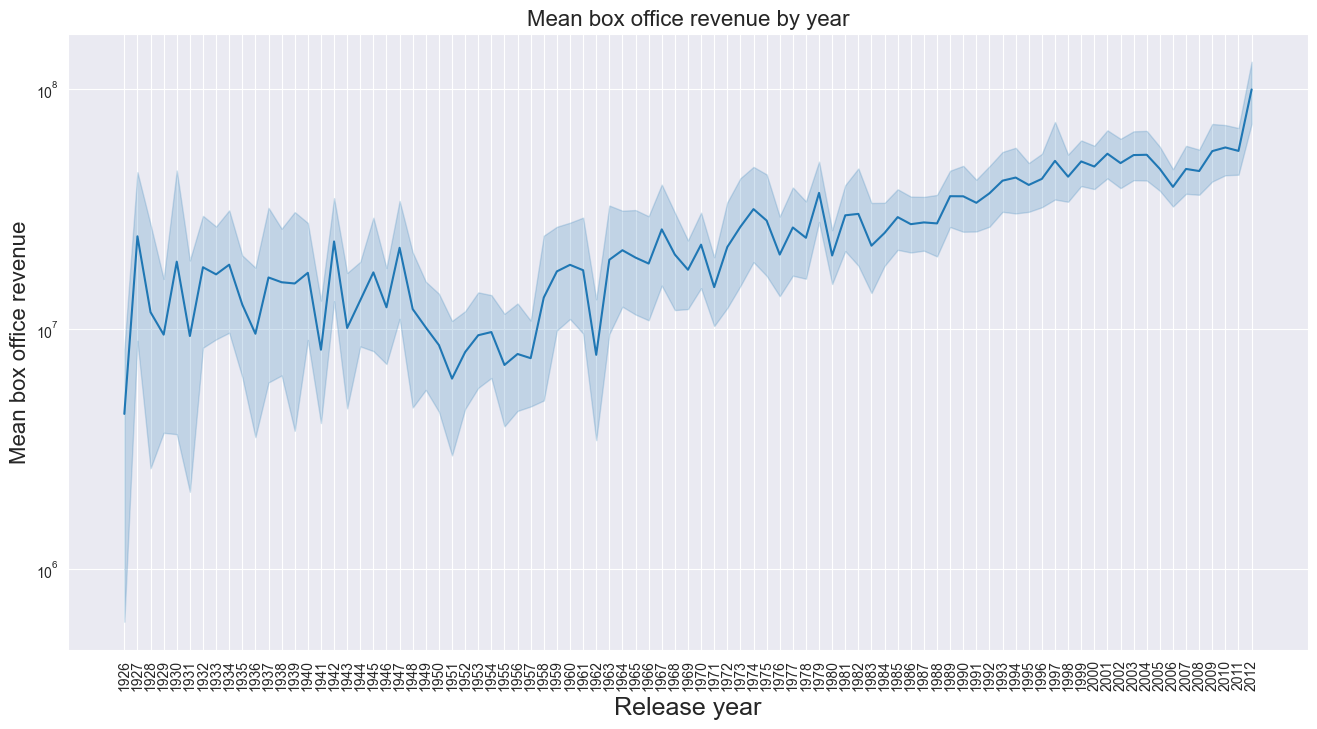

In [30]:
plot_by_year(means_year[80:-10], "Mean", "box office revenue", "Movie box office revenue")

An upwards trend of mean expected revenue is to be expected, especially since more money gets thrown into the film industry:

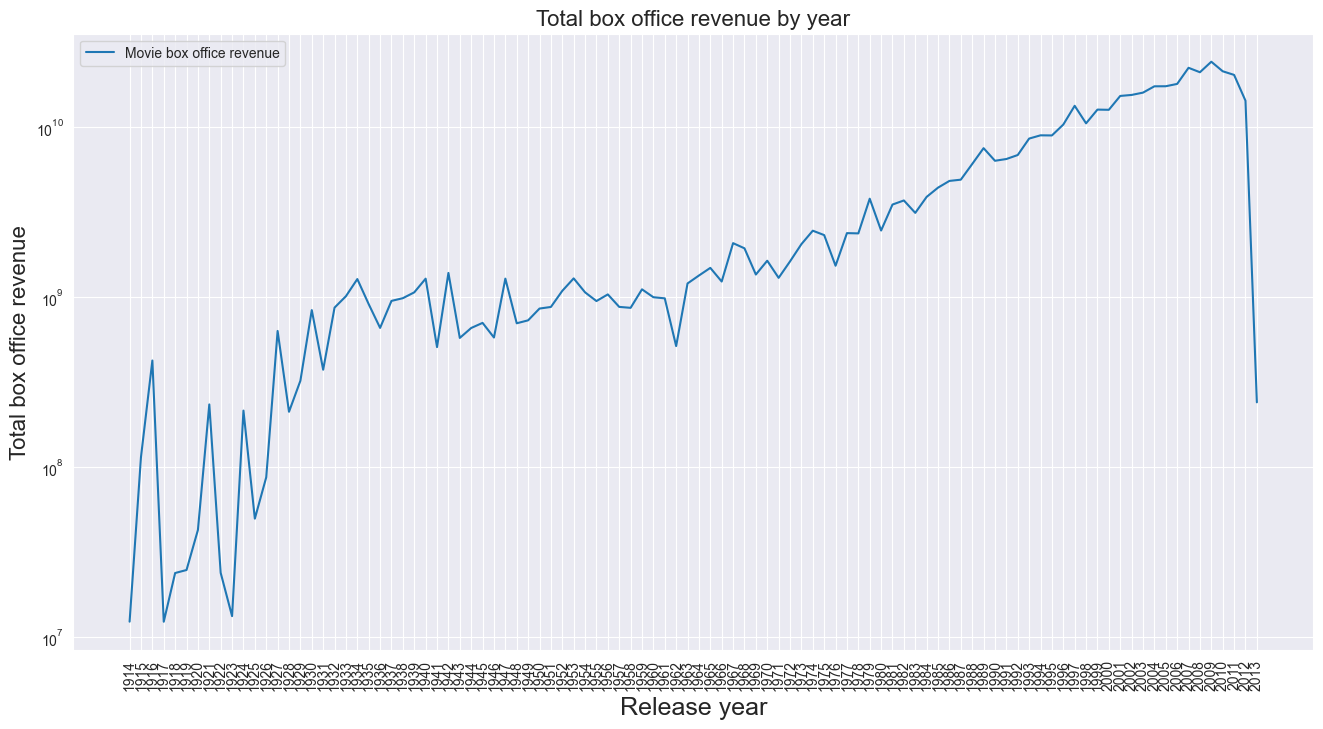

In [31]:
plot_by_year(sums_year, "Total", "box office revenue", "Movie box office revenue")

Now let us do the same for rating:

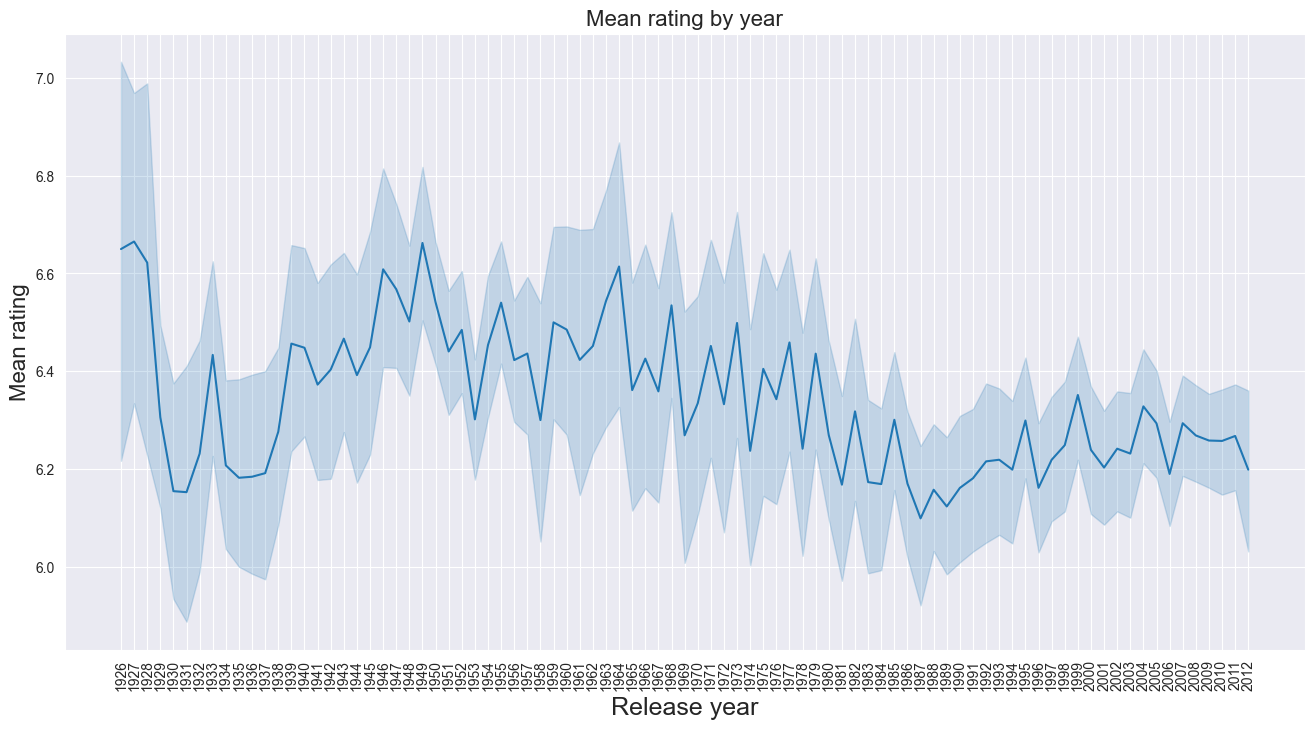

In [32]:
plot_by_year(means_year[80:-10], "Mean", "rating", "averageRating", log_yscale=False)

Interestingly, between the 1960 and the 1985, IMDb average ratings have dropped, before plateauing. We will have to see if this is tied to the number of ratings submitted. Now, what about the dependence between rating and revenue?

In [33]:
stats.spearmanr(metadata_df[box_office_rev], metadata_df[box_office_rat])

SpearmanrResult(correlation=0.09877548158265131, pvalue=2.434463074801704e-28)

The p-value being this small rejects that rating and revenue are uncorrelated. However, that correlation seems to be small. Later, it might be interesting to have a look at this correlation *per year* rather than globally.

Lastly, we also plot the runtime just to check whether there is anything interesting to be seen:

<AxesSubplot: xlabel='Movie runtime', ylabel='Count'>

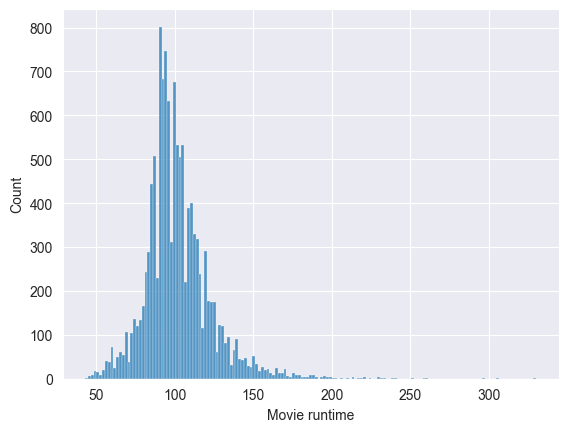

In [34]:
sns.histplot(data=metadata_df["Movie runtime"])

In [35]:
metadata_df["Movie runtime"].describe()

count    12435.000000
mean       101.972280
std         21.335271
min         43.000000
25%         90.000000
50%         99.000000
75%        111.000000
max        330.000000
Name: Movie runtime, dtype: float64

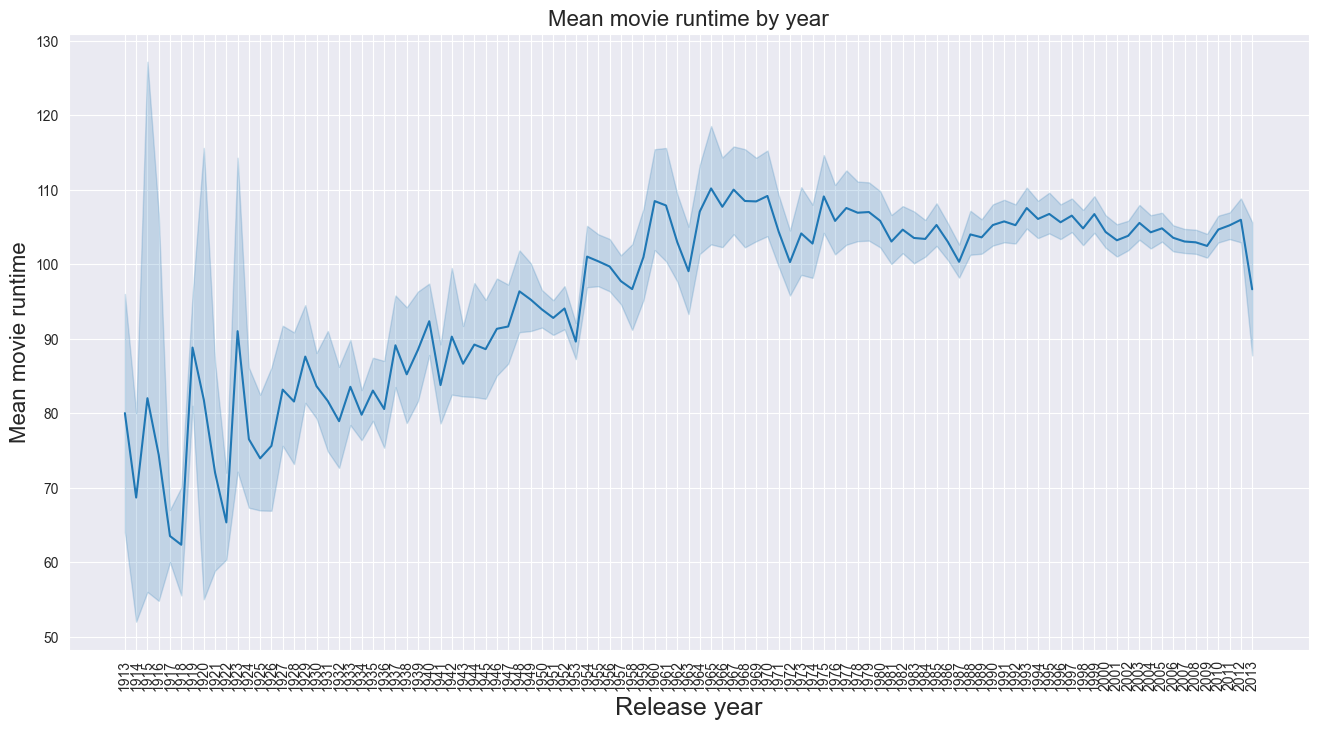

In [36]:
plot_by_year(means_year, "Mean", "movie runtime", "Movie runtime", log_yscale=False)

Runtime has increased during the first half of the 20th century. It might be worth studying how runtime affects rating and revenue.

#### 3.4) Effect of genre, country and language on rating and revenue

We move on to the meat and potatoes of metadata analysis: how genre, country and language affect rating and revenue. Some preprocessing first to add indicator variables for each genre, country and language.

In [37]:
def remove_first_and_last_chars(input_str: str) -> str:
    """
    Remove the first and last char of a string.
    :param input_str
    :return: processed string
    """
    if len(input_str) < 2:
        return ""
    return input_str[1:-1]

def separate_id_from_data(paired_string: str, remove_brackets=True) -> (str, str):
    """
    Separates "{"FreebaseID": "some string"}" strings into ("FreebaseID", "some string") tuples.
    :param paired_string: input paired string
    :param remove_brackets: if True, remove the leading and trailing curly brackets
    :return: said tuple of strings
    """
    if remove_brackets:
        paired_string = remove_first_and_last_chars(paired_string)

    ls = paired_string.split(":")
    for i, s in enumerate(ls):
        ls[i] = remove_first_and_last_chars(s.strip())

    if len(ls) < 2:
        return None, None
    return ls[0], ls[1]

def separate_ids_from_list_data(list_paired_string: str) -> (list, list):
    """
    Separates "{"FreebaseID1": "some string 1", "FreebaseID2": "some string 2", etc.}" strings
    into two lists: (["FreebaseID1", "FreebaseID2", ...], ["some string 1", "some string 2", ...]).
    :param list_paired_string: input list of pairs as string
    :return: said tuple of lists
    """
    list_paired_string = remove_first_and_last_chars(list_paired_string)
    split_pairs = list_paired_string.split(",")
    tupled_pairs = [separate_id_from_data(pair, remove_brackets=False) for pair in split_pairs]
    return [p[0] for p in tupled_pairs], [p[1] for p in tupled_pairs]

def col_to_col_values(column_name: str) -> str:
    """
    String formatting for value column names
    :param column_name: original column name
    :return: said formatted string
    """
    return f"{column_name}: values"

def append_processed_columns(df: pd.DataFrame, column_name: str):
    """
    Separate Freebase IDs from values
    :param df: data, modified in place
    :param column_name: name of column where to separate {Freebase ID: value} pairs
    """
    vals = df[column_name].apply(separate_ids_from_list_data).values.copy()
    df[f"{column_name}: Freebase IDs"] = [vals[i][0] for i in range(len(vals))]
    df[col_to_col_values(column_name)] = [vals[i][1] for i in range(len(vals))]

In [38]:
metadata_df.rename(columns={"Movie countries (Freebase ID:name tuples)": "Movie countries",
                    "Movie genres (Freebase ID:name tuples)": "Movie genres"}, inplace=True)

cols_to_process = ["Movie countries", "Movie genres", "Movie languages"]
for col in cols_to_process:
    append_processed_columns(metadata_df, col)

metadata_df

,Wikipedia movie ID,Freebase movie ID,tconst,primaryTitle,originalTitle,Movie box office revenue,averageRating,numVotes,Movie runtime,Movie languages,...,Movie genres,genres,isAdult,startYear,Movie countries: Freebase IDs,Movie countries: values,Movie genres: Freebase IDs,Movie genres: values,Movie languages: Freebase IDs,Movie languages: values
0,975900,/m/03vyhn,tt0228333,Ghosts of Mars,Ghosts of Mars,14010832.0,4.9,55229,98.0,"{""/m/02h40lc"": ""English Language""}",...,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Action,Horror,Sci-Fi",0,2001,[/m/09c7w0],[United States of America],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/...","[Thriller, Science Fiction, Horror, Adventure,...",[/m/02h40lc],[English Language]
1,28463795,/m/0crgdbh,tt0094806,Brun bitter,Brun bitter,700059566.0,5.7,40,83.0,"{""/m/05f_3"": ""Norwegian Language""}",...,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","Crime,Drama",0,1988,[/m/05b4w],[Norway],"[/m/0lsxr, /m/07s9rl0]","[Crime Fiction, Drama]",[/m/05f_3],[Norwegian Language]
2,261236,/m/01mrr1,tt0083949,A Woman in Flames,Die flambierte Frau,659363944.0,6.0,589,106.0,"{""/m/04306rv"": ""German Language""}",...,"{""/m/07s9rl0"": ""Drama""}",Drama,0,1983,[/m/0345h],[Germany],[/m/07s9rl0],[Drama],[/m/04306rv],[German Language]
6,18998739,/m/04jcqvw,tt0120166,The Sorcerer's Apprentice,The Sorcerer's Apprentice,623357910.0,4.2,605,86.0,"{""/m/02h40lc"": ""English Language""}",...,"{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Adventure,Family,Fantasy",0,2001,[/m/0hzlz],[South Africa],"[/m/0hqxf, /m/01hmnh, /m/03k9fj, /m/03q4nz]","[Family Film, Fantasy, Adventure, World cinema]",[/m/02h40lc],[English Language]
13,12621957,/m/05pdd86,tt0963966,The Sorcerer's Apprentice,The Sorcerer's Apprentice,215283742.0,6.1,162916,111.0,"{""/m/02h40lc"": ""English Language""}",...,"{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...","Action,Adventure,Family",0,2010,[/m/09c7w0],[United States of America],"[/m/06n90, /m/03k9fj, /m/01hmnh, /m/01z4y, /m/...","[Science Fiction, Adventure, Fantasy, Comedy, ...",[/m/02h40lc],[English Language]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86925,1191380,/m/04f_y7,tt0120514,Wilde,Wilde,2158775.0,6.9,17316,118.0,"{""/m/02h40lc"": ""English Language""}",...,"{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...","Biography,Drama,Romance",0,1997,"[/m/014tss, /m/03_3d, /m/02jx1, /m/07ssc, /m/0...","[Kingdom of Great Britain, Japan, England, Uni...","[/m/0hn10, /m/017fp, /m/0gw5n2f, /m/03g3w, /m/...","[LGBT, Biography, Japanese Movies, History, Ga...",[/m/02h40lc],[English Language]
86926,54540,/m/0f7hw,tt0094898,Coming to America,Coming to America,288752301.0,7.1,208493,117.0,"{""/m/02h40lc"": ""English Language""}",...,"{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...","Comedy,Romance",0,1988,[/m/09c7w0],[United States of America],"[/m/06cvj, /m/03p5xs, /m/07s9rl0, /m/01z4y, /m...","[Romantic comedy, Comedy of manners, Drama, Co...",[/m/02h40lc],[English Language]
86931,7761830,/m/0kvgqb,tt0100666,Spaced Invaders,Spaced Invaders,15369573.0,5.3,3738,100.0,"{""/m/02h40lc"": ""English Language""}",...,"{""/m/0hj3mt0"": ""Alien Film"", ""/m/06n90"": ""Scie...","Adventure,Comedy,Sci-Fi",0,1990,[/m/09c7w0],[United States of America],"[/m/0hj3mt0, /m/06n90, /m/0hqxf, /m/01z4y, /m/...","[Alien Film, Science Fiction, Family Film, Com...",[/m/02h40lc],[English Language]
86936,1918494,/m/0660qx,tt0120202,State and Main,State and Main,6944471.0,6.7,21482,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...",...,"{""/m/0gf28"": ""Parody"", ""/m/09n5t_"": ""Americana...","Comedy,Drama",0,2000,"[/m/0f8l9c, /m/09c7w0]","[France, United States of America]","[/m/0gf28, /m/09n5t_, /m/01z4y]","[Parody, Americana, Comedy]","[/m/02bjrlw, /m/02h40lc]","[Italian Language, English Language]"


In [39]:
def distinct_values(column_name: str) -> set:
    """
    Get all values from a column
    :param column_name: said column
    :return: set of values
    """
    return set.union(*metadata_df[col_to_col_values(column_name)].apply(set).values)

def name_appended_column(prefix: str, val: str) -> str:
    """
    Format column name
    :param prefix: str
    :param val: str
    :return: str
    """
    return f"{prefix}: {val}"

def append_indicator_columns(df: pd.DataFrame, all_values: set, column_name: str, prefix: str) -> pd.DataFrame:
    """
    Add columns to the right of a dataframe indicating whether a particular value is present or not
    in some initial column listing values of the same family
    :param df: data (not modified)
    :param all_values: all possible values
    :param column_name: column to inspect
    :param prefix: str
    :return: Dataframe with added columns
    """
    cols = [df[col_to_col_values(column_name)]
            .apply(lambda x: 1 if val in x else 0)
            .rename(name_appended_column(prefix, val))
            for val in all_values]
    cols.insert(0, df)
    return pd.concat(cols, axis=1)

Store all genres and countries encountered:

In [40]:
all_countries = distinct_values("Movie countries")
all_genres = distinct_values("Movie genres")
all_languages = distinct_values("Movie languages")

genre_prefix = "genre"
langs_prefix = "lang"
cntry_prefix = "country"

Then, let's check the resulting dataframe:

In [41]:
for ls in [(all_countries, "Movie countries", cntry_prefix),
            (all_genres, "Movie genres", genre_prefix),
            (all_languages, "Movie languages", langs_prefix)]:
    metadata_df = append_indicator_columns(metadata_df, *ls)

metadata_df

,Wikipedia movie ID,Freebase movie ID,tconst,primaryTitle,originalTitle,Movie box office revenue,averageRating,numVotes,Movie runtime,Movie languages,...,lang: Old English language,lang: May,lang: Filipino language,lang: Wolof Language,lang: Romanian Language,lang: Spanish Language,lang: Telugu language,lang: Mongolian language,lang: Krio Language,lang: Irish
0,975900,/m/03vyhn,tt0228333,Ghosts of Mars,Ghosts of Mars,14010832.0,4.9,55229,98.0,"{""/m/02h40lc"": ""English Language""}",...,0,0,0,0,0,0,0,0,0,0
1,28463795,/m/0crgdbh,tt0094806,Brun bitter,Brun bitter,700059566.0,5.7,40,83.0,"{""/m/05f_3"": ""Norwegian Language""}",...,0,0,0,0,0,0,0,0,0,0
2,261236,/m/01mrr1,tt0083949,A Woman in Flames,Die flambierte Frau,659363944.0,6.0,589,106.0,"{""/m/04306rv"": ""German Language""}",...,0,0,0,0,0,0,0,0,0,0
6,18998739,/m/04jcqvw,tt0120166,The Sorcerer's Apprentice,The Sorcerer's Apprentice,623357910.0,4.2,605,86.0,"{""/m/02h40lc"": ""English Language""}",...,0,0,0,0,0,0,0,0,0,0
13,12621957,/m/05pdd86,tt0963966,The Sorcerer's Apprentice,The Sorcerer's Apprentice,215283742.0,6.1,162916,111.0,"{""/m/02h40lc"": ""English Language""}",...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86925,1191380,/m/04f_y7,tt0120514,Wilde,Wilde,2158775.0,6.9,17316,118.0,"{""/m/02h40lc"": ""English Language""}",...,0,0,0,0,0,0,0,0,0,0
86926,54540,/m/0f7hw,tt0094898,Coming to America,Coming to America,288752301.0,7.1,208493,117.0,"{""/m/02h40lc"": ""English Language""}",...,0,0,0,0,0,0,0,0,0,0
86931,7761830,/m/0kvgqb,tt0100666,Spaced Invaders,Spaced Invaders,15369573.0,5.3,3738,100.0,"{""/m/02h40lc"": ""English Language""}",...,0,0,0,0,0,0,0,0,0,0
86936,1918494,/m/0660qx,tt0120202,State and Main,State and Main,6944471.0,6.7,21482,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...",...,0,0,0,0,0,0,0,0,0,0


For pragmatic purposes such as visualization, we will only treat, in the following, either the $n$ most frequent genres, or genres that are sufficiently frequent.

In [42]:
from functools import cmp_to_key

def retrieve_n_most_frequent(df: pd.DataFrame, n: int, all_vals: list[str], prefix: str) -> list:
    """
    Retrieve the n most frequent genres, languages or countries, sorted in descending order
    of frequency
    :param df: data
    :param n: integer, max number of values to retrieve
    :param all_vals: all possible values
    :param prefix: str
    :return: said list
    """
    def comparator(val1, val2):
        mean_val1 = df[name_appended_column(prefix, val1)].mean()
        mean_val2 = df[name_appended_column(prefix, val2)].mean()
        return mean_val1 - mean_val2
    return sorted(all_vals, key=cmp_to_key(comparator), reverse=True)[:n]

def retrieve_frequent(df: pd.DataFrame, all_vals: list, prefix: str, freq_threshold=0.05) -> list:
    """
    Filter the values with a sufficiently high frequency
    :param df: data
    :param all_vals: all possible values
    :param prefix: str
    :param freq_threshold: float
    :return: list of sufficiently frequent values
    """
    return list(
        filter(
            lambda val: df[name_appended_column(prefix, val)].mean() > freq_threshold,
            all_vals
        )
    )

def map_to_col_names(data_names: list, prefix: str) -> list:
    """
    Convert data values into column names
    :param data_names: list of  data values
    :param prefix: str
    :return: list of formatted column names
    """
    f = lambda x: name_appended_column(prefix, x)
    return list(map(f, data_names))

In [43]:
most_freq_genres = retrieve_n_most_frequent(metadata_df, 35, all_genres, genre_prefix)
suff_freq_genres = retrieve_frequent(metadata_df, all_genres, genre_prefix, freq_threshold=0.03)

most_freq_langs = retrieve_n_most_frequent(metadata_df, 35, all_languages, langs_prefix)
suff_freq_langs = retrieve_frequent(metadata_df, all_languages, langs_prefix, freq_threshold=0.03)

most_freq_cntry = retrieve_n_most_frequent(metadata_df, 35, all_countries, cntry_prefix)
suff_freq_cntry = retrieve_frequent(metadata_df, all_countries, cntry_prefix, freq_threshold=0.03)

Our next step will be to examine genres, countries and languages that have are correlated to rating and revenue, and try to understand which ones optimize either metric.

In [44]:
def find_correlated_metadata(df: pd.DataFrame, freq_data: list, success_metric: str, prefix: str, sig_level=0.05) -> list:
    """
    Among a list of sufficiently frequent data taken from the metadata dataframe,
    find the values such that they are correlated to a movie's success metric with
    a p-value less than sig-level.
    :param df: input dataframe
    :param freq_data: column names to search in
    :param success_metric: str, name of column in df
    :param prefix: str
    :param sig_level: significance level, defaults to 5%
    :return: described list
    """
    correlated_data = []

    for value in freq_data:
        res = stats.spearmanr(df[success_metric], df[name_appended_column(prefix, value)])
        if res.pvalue < sig_level:
            correlated_data.append(value)
    return correlated_data

In [45]:
correlated_genres_to_revenue = find_correlated_metadata(metadata_df, suff_freq_genres, box_office_rev, genre_prefix)
correlated_langs_to_revenue = find_correlated_metadata(metadata_df, most_freq_langs, box_office_rev, langs_prefix)
correlated_cntry_to_revenue = find_correlated_metadata(metadata_df, most_freq_cntry, box_office_rev, cntry_prefix)

correlated_genres_to_rating = find_correlated_metadata(metadata_df, suff_freq_genres, box_office_rat, genre_prefix)
correlated_langs_to_rating = find_correlated_metadata(metadata_df, most_freq_langs, box_office_rat, langs_prefix)
correlated_cntry_to_rating = find_correlated_metadata(metadata_df, most_freq_cntry, box_office_rat, cntry_prefix)

In [46]:
def plot_metadata_frequency_against_metric(df: pd.DataFrame, prefix: str,  titled_data: list, success_metric: str, title: str, log_scale=True):
    """
    Generating a grid of histograms
    :param df: data
    :param prefix: str
    :param titled_data: titles of data, to be converted to column names
    :param success_metric: measured column name
    :param title: str, figure title
    :param log_scale: determines the scale of the axes
    """

    # Making the data fit into a square grid...
    squares = np.arange(8) ** 2
    shifted_squares = squares - len(titled_data)
    smallest_big_enough_square = squares[np.argmax(shifted_squares > 0) - 1]

    tested_data = map_to_col_names(titled_data, prefix)[:smallest_big_enough_square]
    size = int(np.sqrt(smallest_big_enough_square))

    fig, ax = plt.subplots(size, size, figsize=(11, 11), sharex = True)
    for i in range(smallest_big_enough_square):
        sbplt = ax[i%size, math.floor(i/size)]
        sns.histplot(ax=sbplt, data=df[df[tested_data[i]] == 1][success_metric], log_scale=log_scale)
        sbplt.set_title(titled_data[i])

    fig.suptitle(title, fontsize=18)
    fig.tight_layout()

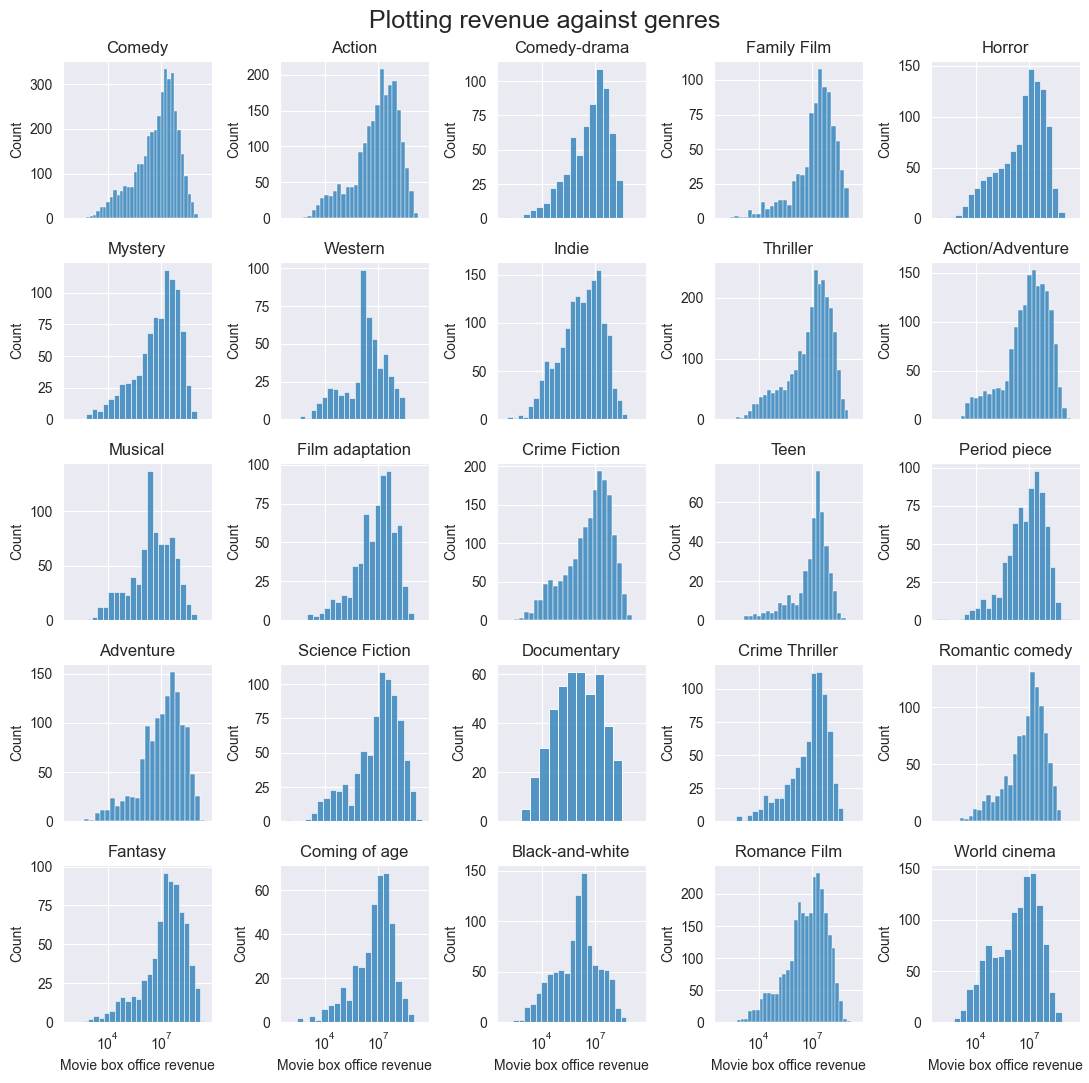

In [47]:
plot_metadata_frequency_against_metric(metadata_df, genre_prefix, correlated_genres_to_revenue, box_office_rev, title="Plotting revenue against genres")

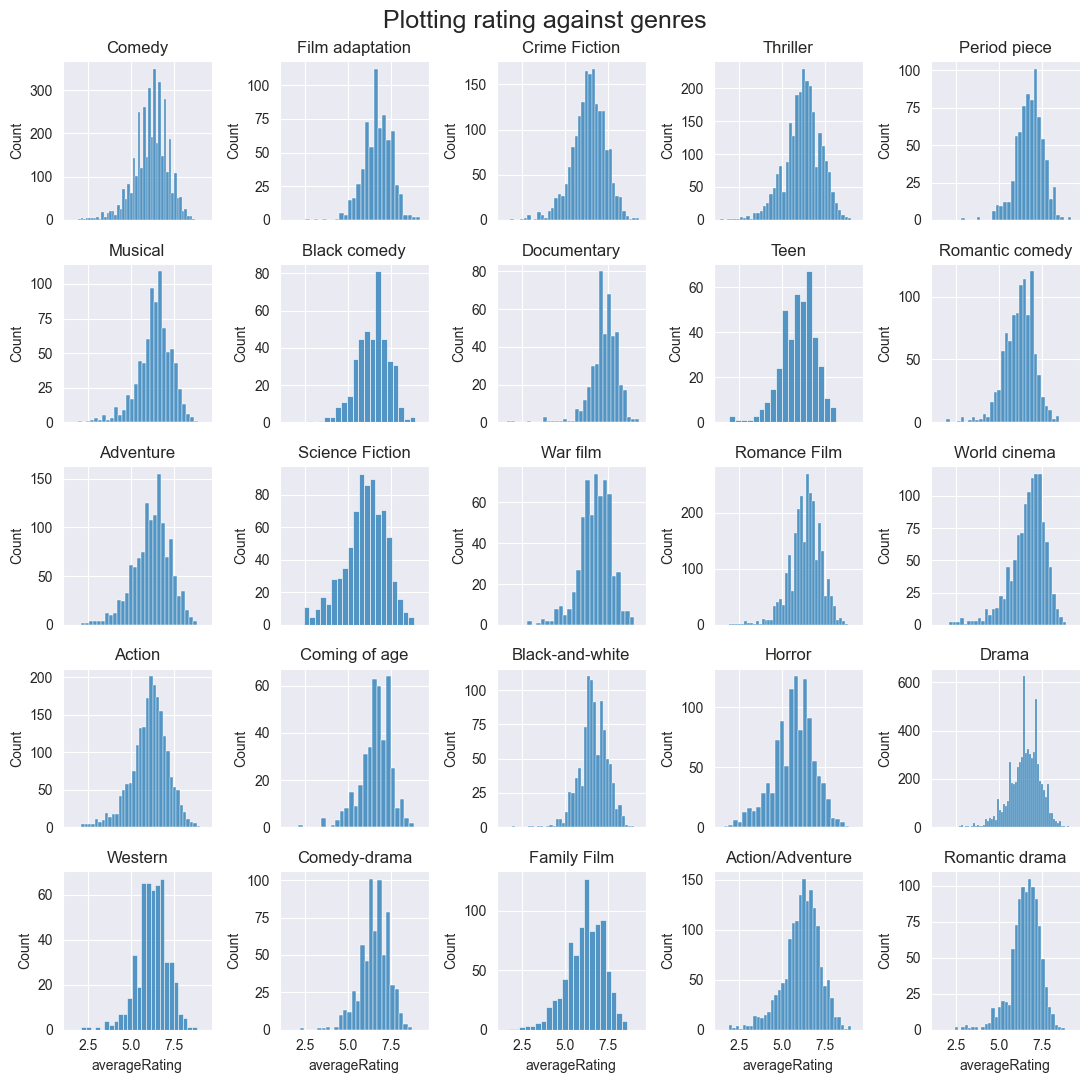

In [48]:
plot_metadata_frequency_against_metric(metadata_df, genre_prefix, correlated_genres_to_rating, box_office_rat, title="Plotting rating against genres", log_scale=False)

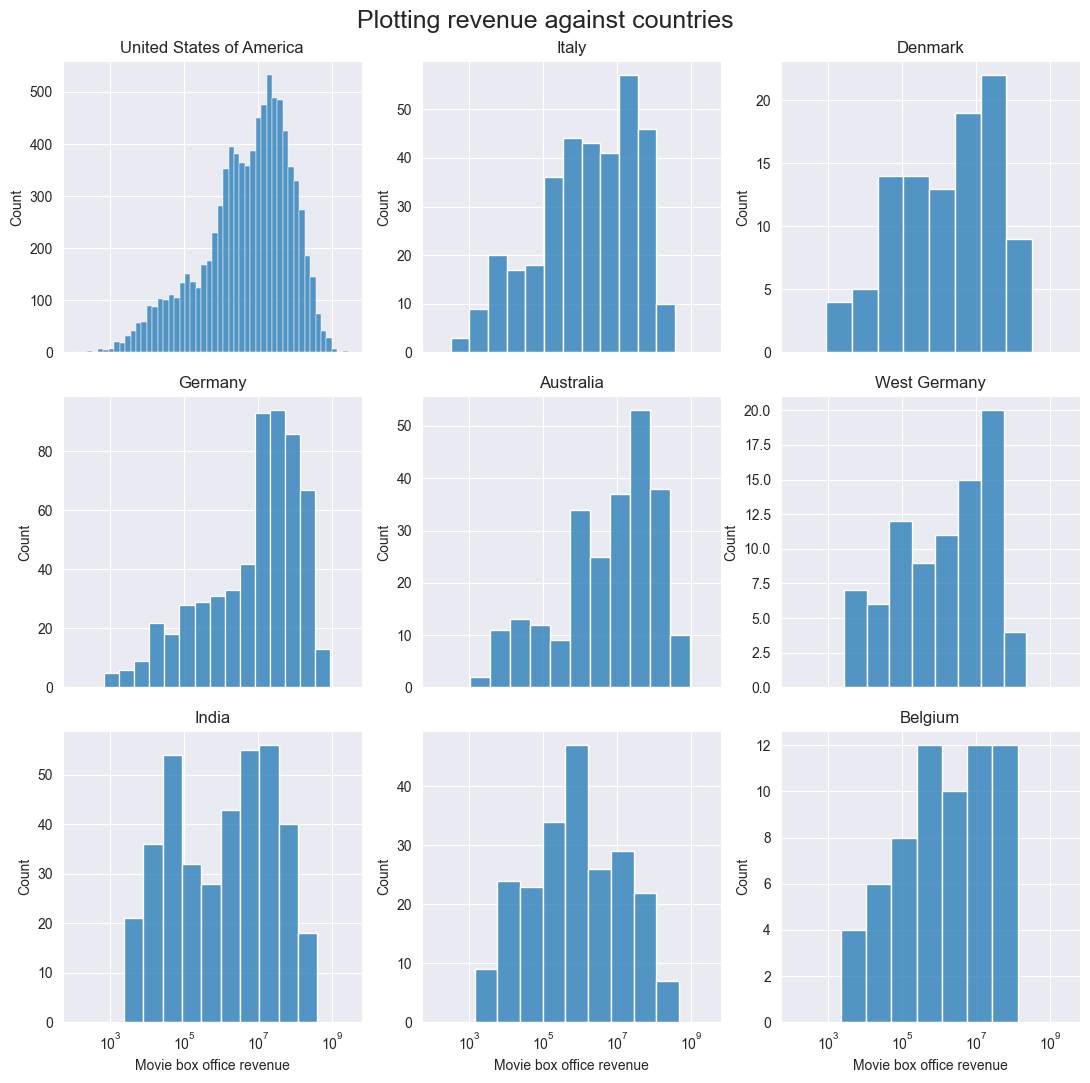

In [49]:
plot_metadata_frequency_against_metric(metadata_df, cntry_prefix, correlated_cntry_to_revenue, box_office_rev, title="Plotting revenue against countries")

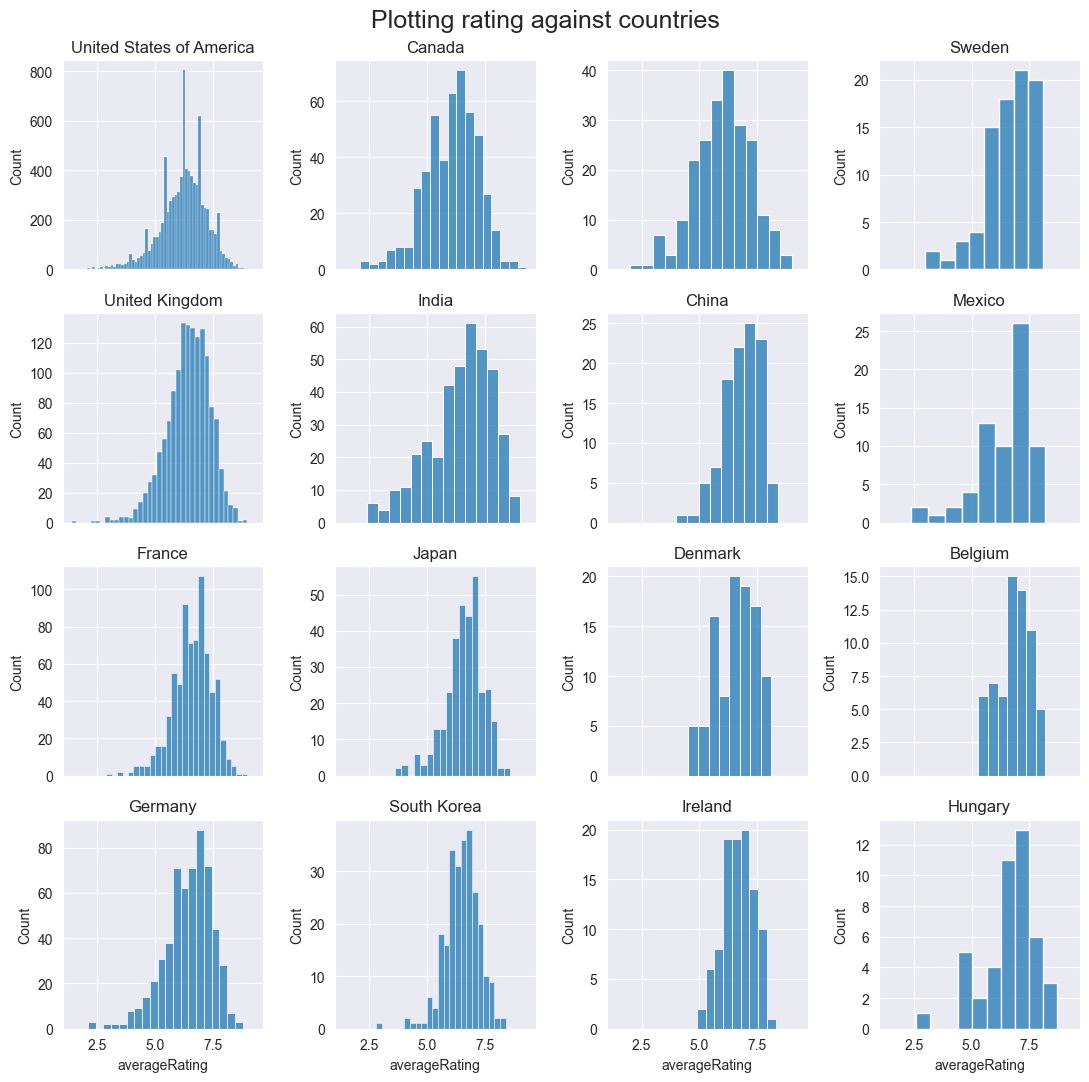

In [50]:
plot_metadata_frequency_against_metric(metadata_df, cntry_prefix, correlated_cntry_to_rating, box_office_rat, title="Plotting rating against countries", log_scale=False)

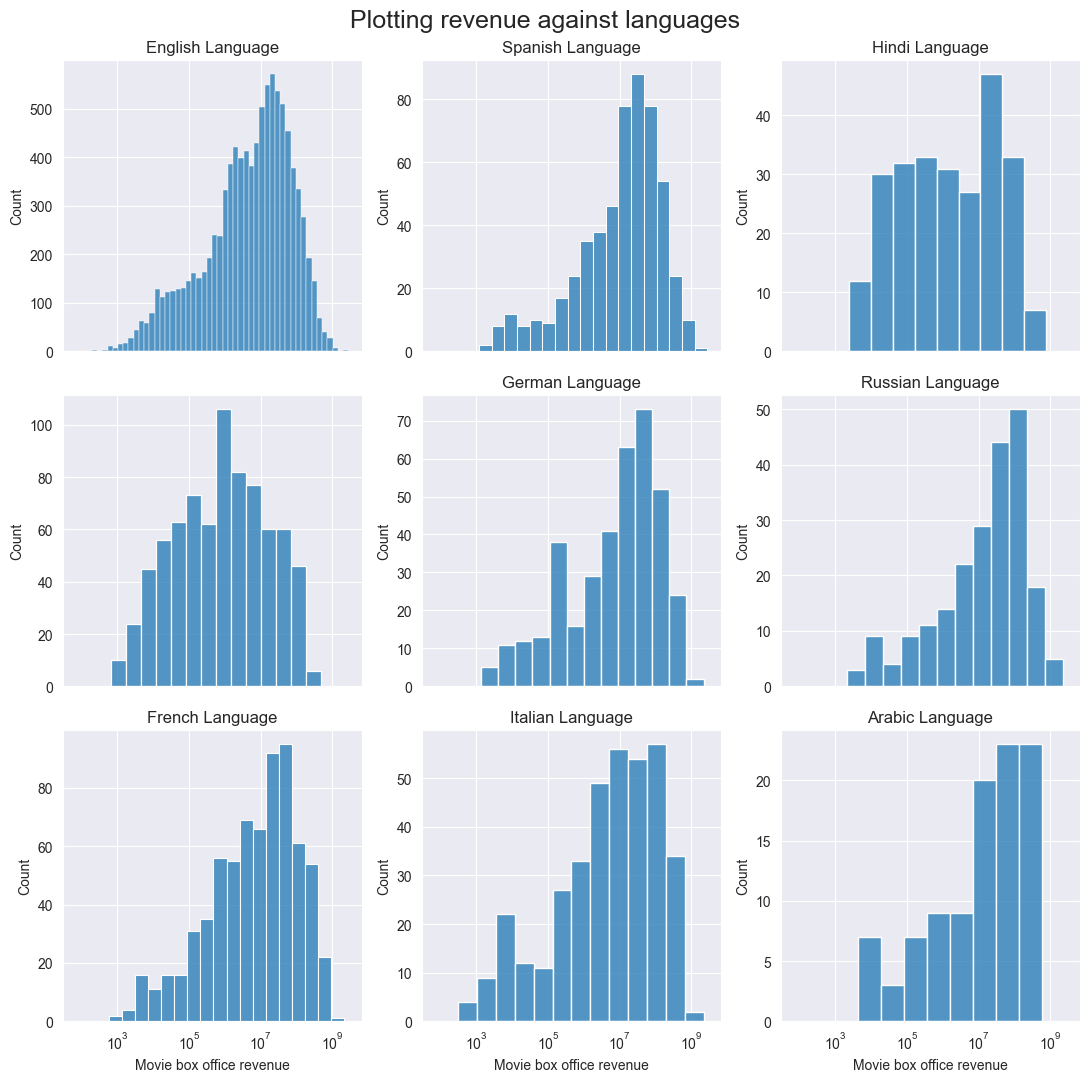

In [51]:
plot_metadata_frequency_against_metric(metadata_df, langs_prefix, correlated_langs_to_revenue, box_office_rev, title="Plotting revenue against languages")

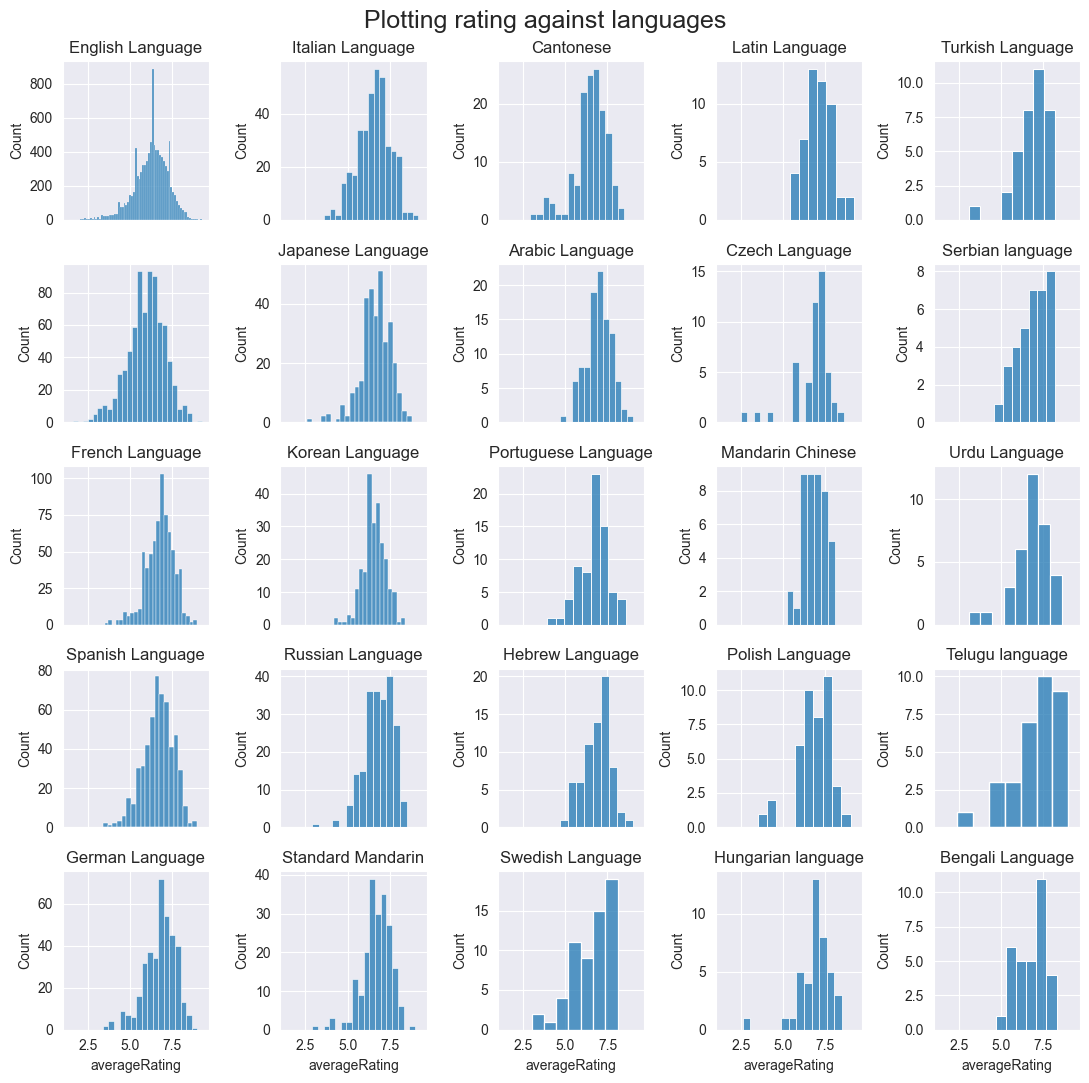

In [52]:
plot_metadata_frequency_against_metric(metadata_df, langs_prefix, correlated_langs_to_rating, box_office_rat, title="Plotting rating against languages", log_scale=False)

Interesting differences can already be seen. For example, the 3 initial peaks in the rating histogram have become 5 peaks in English drama movies coming from the US. Later, it will be interesting to check the correlation of rating and revenue on a *per year* basis too.

### 4) Actors Metadata analysis

Here we focus on analysing the characters metadata in ``charcater.metadata.tsv``

In [53]:
# Load the dataset
names_char = ['Wikipedia movie ID',
              'Freebase movie ID',
              'Movie release date',
              'Character name',
              'Actor date of birth',
              'Actor gender',
              'Actor height',
              'Actor ethnicity',
              'Actor name',
              'Actor age at movie release',
              'Freebase character/actor map ID',
              'Freebase character ID',
              'Freebase actor ID']

characters_metadata_df = pd.read_csv('data/character.metadata.tsv', sep='\t', names = names_char)

In [54]:
characters_metadata_df.head()

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [55]:
characters_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Wikipedia movie ID               450669 non-null  int64  
 1   Freebase movie ID                450669 non-null  object 
 2   Movie release date               440674 non-null  object 
 3   Character name                   192794 non-null  object 
 4   Actor date of birth              344524 non-null  object 
 5   Actor gender                     405060 non-null  object 
 6   Actor height                     154824 non-null  float64
 7   Actor ethnicity                  106058 non-null  object 
 8   Actor name                       449441 non-null  object 
 9   Actor age at movie release       292556 non-null  float64
 10  Freebase character/actor map ID  450669 non-null  object 
 11  Freebase character ID            192804 non-null  object 
 12  Fr

In [56]:
characters_metadata_df['Actor gender'].describe()

count     405060
unique         2
top            M
freq      270257
Name: Actor gender, dtype: object

##### Age at movie release:

In [57]:
characters_metadata_df['Actor age at movie release'].describe()

count    292556.000000
mean         37.788523
std          20.587870
min       -7896.000000
25%          28.000000
50%          36.000000
75%          47.000000
max         103.000000
Name: Actor age at movie release, dtype: float64

We noticed that the attribute 'Age at movie release' contains negative values

In [58]:
characters_metadata_df[characters_metadata_df['Actor age at movie release'] < 0]

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
767,15007384,/m/03h4h5p,1934-05-02,NaN,1963-11-07,NaN,NaN,NaN,Franck Dubosc,-29.0,/m/0bwb9k3,NaN,/m/01wlly9
2286,2553539,/m/07mlsy,1918-04-14,NaN,1931-03-25,M,NaN,NaN,Tom Wilson,-12.0,/m/0jsqm1,NaN,/m/0382zh
3892,5917218,/m/0fdf3y,1965,NaN,1983-03-03,F,1.75,NaN,Kim Smith,-18.0,/m/04mb5kf,NaN,/m/03pjkv
6666,73930,/m/0jsjm,1924,Robert,1972-11-07,M,1.80,NaN,Jason London,-48.0,/m/01xrptw,/m/02nwfsk,/m/04kdmg
7188,21242801,/m/05bzjwj,1955-08-07,NaN,1973-08-01,M,1.79,/m/03ttfc,Eduardo Noriega,-17.0,/m/0cg2f0f,NaN,/m/0bkkw0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
446570,3642891,/m/09rsyj,1999-10-03,Tess,2936-12-24,F,NaN,NaN,J.J. McColl,-937.0,/m/0l2rdfz,/m/0l2rdg1,/m/0l2rdg8
446581,25868401,/m/09v6ykm,1955,NaN,1967-05-31,F,1.67,/m/03ts0c,Sandrine Bonnaire,-12.0,/m/04j05tr,NaN,/m/07wn_5
446583,8595532,/m/02799cv,1944-02-23,NaN,1947-05-28,M,NaN,NaN,Kevin O'Shea,-3.0,/m/02vcqnq,NaN,/m/02q384f
446816,1276915,/m/04pg6m,1941-06-20,NaN,1957-04-19,M,NaN,NaN,Tony Martin,-15.0,/m/0cg164j,NaN,/m/07q_fg


In [59]:
characters_metadata_df['Actor age at movie release'] = characters_metadata_df['Actor age at movie release'].apply(abs)

(0.0, 100.0)

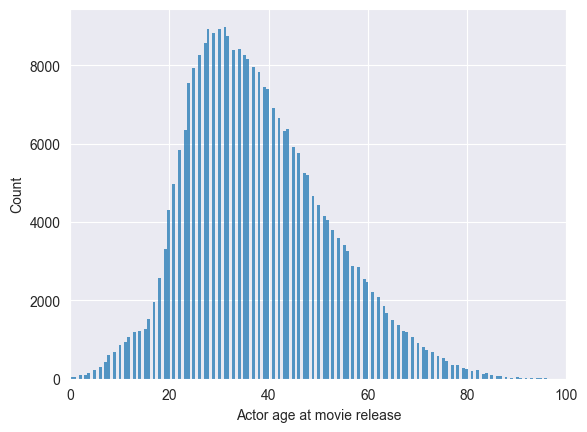

In [60]:
sns.histplot(data=characters_metadata_df, x="Actor age at movie release")
plt.xlim(0, 100)

##### Titles known for:
Since our study focuses on analysing features that contribute to a movie's success, it would be relevant to study actors performance. This can be done by having information on when each actor performed the best.
For this task, we used the  ``imdb_name_basics.tsv`` dataset, which contains the 4 topmost titles an actor is known for.

**IMDb actors dataset:**

- **nconst**: unique identifier of person
- **primaryName**: name the person is known for
- **birthYear**: birth year
- **deathYear**: death year
- **primaryProfession**: top 3 professions of the person
- **knownForTitles**: movies the person is known for


In [61]:
# Load the IMDb actors dataset
imdb_actors_df = pd.read_csv('data/imdb_name_basics.tsv', sep='	')

In [62]:
imdb_actors_df.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0031983,tt0072308,tt0050419,tt0053137"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0071877,tt0117057,tt0037382,tt0038355"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0049189,tt0054452,tt0056404,tt0057345"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0078723,tt0077975,tt0080455,tt0072562"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0083922,tt0050976,tt0060827,tt0050986"


In [63]:
imdb_actors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12060121 entries, 0 to 12060120
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   nconst             object
 1   primaryName        object
 2   birthYear          object
 3   deathYear          object
 4   primaryProfession  object
 5   knownForTitles     object
dtypes: object(6)
memory usage: 552.1+ MB


Since we only have the id of the known for titles, we fetch the title names from the `imdb_names_df`

First we separate each of the titles ids an actor is known for in a single column, then we fetch the name corresponding to each id.

In [64]:
def get_title_by_index(index):
    """
    Returns the title id at a given index
    :param index: The id index in the list of ids
    :return: The id
    """
    def f(array):
        list_ids = array.split(",")
        corresponding_id = ""
        if index < len(list_ids):
            corresponding_id = list_ids[index]
        return corresponding_id

    return f

imdb_actors_df['knownForTitles1'] = imdb_actors_df['knownForTitles'].apply(get_title_by_index(0))
imdb_actors_df['knownForTitles2'] = imdb_actors_df['knownForTitles'].apply(get_title_by_index(1))
imdb_actors_df['knownForTitles3'] = imdb_actors_df['knownForTitles'].apply(get_title_by_index(2))
imdb_actors_df['knownForTitles4'] = imdb_actors_df['knownForTitles'].apply(get_title_by_index(3))

In [65]:
imdb_actors_df.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,knownForTitles1,knownForTitles2,knownForTitles3,knownForTitles4
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0031983,tt0072308,tt0050419,tt0053137",tt0031983,tt0072308,tt0050419,tt0053137
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0071877,tt0117057,tt0037382,tt0038355",tt0071877,tt0117057,tt0037382,tt0038355
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0049189,tt0054452,tt0056404,tt0057345",tt0049189,tt0054452,tt0056404,tt0057345
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0078723,tt0077975,tt0080455,tt0072562",tt0078723,tt0077975,tt0080455,tt0072562
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0083922,tt0050976,tt0060827,tt0050986",tt0083922,tt0050976,tt0060827,tt0050986


In [66]:
# IMDb movies' metadata dataset
imdb_names_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
610,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama


In [67]:
# Keep only relevant columns
imdb_names_reduced_df = imdb_names_df[["tconst", "primaryTitle"]]

In [68]:
def assign_known_title(index, actors_df, names_df):
    """
    Fetch the known titles names
    :param index: Index of the title in the list
    :param actors_df: actors dataframe
    :param names_df: movie names dataframe
    :return:
    """
    actors_df = actors_df.merge(names_df, left_on="knownForTitles{}".format(index), right_on = 'tconst', how='inner')
    actors_df["knownForTitles{}".format(index)] = actors_df['primaryTitle']
    actors_df = actors_df.drop('tconst', axis=1)
    actors_df = actors_df.drop('primaryTitle', axis=1)
    return actors_df

In [69]:
imdb_actors_df = assign_known_title(1, imdb_actors_df, imdb_names_reduced_df)
imdb_actors_df = assign_known_title(2, imdb_actors_df, imdb_names_reduced_df)
imdb_actors_df = assign_known_title(3, imdb_actors_df, imdb_names_reduced_df)
imdb_actors_df = assign_known_title(4, imdb_actors_df, imdb_names_reduced_df)

In [70]:
imdb_actors_df.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,knownForTitles1,knownForTitles2,knownForTitles3,knownForTitles4
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0031983,tt0072308,tt0050419,tt0053137",The Story of Vernon and Irene Castle,The Towering Inferno,Funny Face,On the Beach
1,nm0461772,Frederic Knudtson,1906,1964,"editor,editorial_department","tt0053946,tt0055031,tt0057193,tt0053137",Inherit the Wind,Judgment at Nuremberg,It's a Mad Mad Mad Mad World,On the Beach
2,nm0254666,Walter Elliott,1903,1984,"sound_department,music_department","tt0057193,tt0053946,tt0055031,tt0053137",It's a Mad Mad Mad Mad World,Inherit the Wind,Judgment at Nuremberg,On the Beach
3,nm1298827,Marie Cowan,\N,\N,"soundtrack,composer","tt0455824,tt0220134,tt0105824,tt0053137",Australia,Up Jumped a Swagman,Wind,On the Beach
4,nm0542596,Nellie Manley,1894,1976,make_up_department,"tt0052357,tt0054698,tt0050419,tt0051201",Vertigo,Breakfast at Tiffany's,Funny Face,Witness for the Prosecution


In [71]:
imdb_actors_df['knownForTitlesNames'] = imdb_actors_df[imdb_actors_df.columns[6:]].apply(
    lambda x: ','.join(x),
    axis=1
)

In [72]:
imdb_actors_df = imdb_actors_df.drop('knownForTitles1', axis = 1).drop('knownForTitles2', axis = 1).drop('knownForTitles3', axis = 1).drop('knownForTitles4', axis = 1)

In [73]:
imdb_actors_df.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,knownForTitlesNames
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0031983,tt0072308,tt0050419,tt0053137","The Story of Vernon and Irene Castle,The Tower..."
1,nm0461772,Frederic Knudtson,1906,1964,"editor,editorial_department","tt0053946,tt0055031,tt0057193,tt0053137","Inherit the Wind,Judgment at Nuremberg,It's a ..."
2,nm0254666,Walter Elliott,1903,1984,"sound_department,music_department","tt0057193,tt0053946,tt0055031,tt0053137","It's a Mad Mad Mad Mad World,Inherit the Wind,..."
3,nm1298827,Marie Cowan,\N,\N,"soundtrack,composer","tt0455824,tt0220134,tt0105824,tt0053137","Australia,Up Jumped a Swagman,Wind,On the Beach"
4,nm0542596,Nellie Manley,1894,1976,make_up_department,"tt0052357,tt0054698,tt0050419,tt0051201","Vertigo,Breakfast at Tiffany's,Funny Face,Witn..."


As an example, let's see what are the titles Leonardo Dicaprio is known for

In [74]:
result = imdb_actors_df[imdb_actors_df['primaryName'] == "Leonardo DiCaprio"]['knownForTitlesNames']
print(result)

13266    The Wolf of Wall Street,Titanic,The Departed,I...
Name: knownForTitlesNames, dtype: object


No surprise !

We add the IMDb's casting dataset. It contains the people that have participated in castings for movies and their role in them.
We are not directly using this dataframe in Milestone 2 as it will be joined and applied to data obtained by methods in Milestone 3 (refer to Method 2 at Readme for further information).

**IMDb castings dataset:**

- **tconst**: unique identifier of title
- **ordering**: index identify a row within a specific title
- **nconst**: unique identifier of person
- **category**: category of job in casting
- **job**: job title
- **characters**: name of character if it was an interpretation role

In [75]:
# IMDb castings dataset
imdb_casting_df = pd.read_csv('data/imdb_title_principals.tsv', sep='	', low_memory=False)
imdb_names_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
610,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama


### 5) tvtropes clusters analysis

Here we use the clusters in ``tvtropes.clusters.txt`` to see what type of characters an actor tends to play.

In [76]:
# Load the data into a dataframe
with open('data/tvtropes.clusters.txt') as f:
    d = []
    for row in f.readlines():
        t, json_data = row.split('\t')
        data = json.loads(json_data)
        data['type'] = t
        d.append(data)

tv_tropes_df = pd.DataFrame(d)
tv_tropes_df.set_index("id", inplace=True)

In [77]:
tv_tropes_df.head()

,char,movie,actor,type
id,,,,
/m/0jy9q0,Professor Philip Brainard,Flubber,Robin Williams,absent_minded_professor
/m/02vchl3,Professor Keenbean,Richie Rich,Michael McShane,absent_minded_professor
/m/0k6fkc,Dr. Reinhardt Lane,The Shadow,Ian McKellen,absent_minded_professor
/m/0k6_br,Dr. Harold Medford,Them!,Edmund Gwenn,absent_minded_professor
/m/0k3rhh,Daniel Jackson,Stargate,James Spader,absent_minded_professor


In [78]:
# split the type in tokens
tv_tropes_df['type'] = tv_tropes_df['type'].apply(lambda x: ' '.join(x.split('_')))

In [79]:
tv_tropes_df['type'].head()

id
/m/0jy9q0     absent minded professor
/m/02vchl3    absent minded professor
/m/0k6fkc     absent minded professor
/m/0k6_br     absent minded professor
/m/0k3rhh     absent minded professor
Name: type, dtype: object

In order to have better insight on the data and also for further analysis on what type of characters are played by each actor, we decide to conduct sentiment analysis on those type. For this task we use the nltk library.

In [80]:
# Load the model
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\diced\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [81]:
# Initialization and example
sia = SentimentIntensityAnalyzer()
sia.polarity_scores('adventurer archeologist')

{'neg': 0.0, 'neu': 0.312, 'pos': 0.688, 'compound': 0.296}

In [82]:
def get_sentiment(sentence):
    """
    Compute the sentiment value of a sentence
    :param sentence: The sentence
    :return: -1 for negative, 0 for neutral and 1 for positive
    """
    score = sia.polarity_scores(sentence)
    # If the score is more positive with a less significant neutral value and vice versa
    if score['pos'] > score['neg'] and score['neu'] < 0.5: return 1
    elif score['pos'] < score['neg'] and score['neu'] < 0.5: return -1
    else: return 0

In [83]:
# Create a column sentiment containing the sentiment value of the character type
tv_tropes_df['sentiment'] = tv_tropes_df['type'].apply(get_sentiment).to_frame()

In [84]:
tv_tropes_df.head(10)

,char,movie,actor,type,sentiment
id,,,,,
/m/0jy9q0,Professor Philip Brainard,Flubber,Robin Williams,absent minded professor,0
/m/02vchl3,Professor Keenbean,Richie Rich,Michael McShane,absent minded professor,0
/m/0k6fkc,Dr. Reinhardt Lane,The Shadow,Ian McKellen,absent minded professor,0
/m/0k6_br,Dr. Harold Medford,Them!,Edmund Gwenn,absent minded professor,0
/m/0k3rhh,Daniel Jackson,Stargate,James Spader,absent minded professor,0
/m/0jzx78,Indiana Jones,Indiana Jones and the Kingdom of the Crystal S...,Harrison Ford,adventurer archaeologist,1
/m/0k294p,Indiana Jones,Indiana Jones and the Raiders of the Lost Ark,Harrison Ford,adventurer archaeologist,1
/m/0jzx9b,Indiana Jones,Indiana Jones and the Temple of Doom,Harrison Ford,adventurer archaeologist,1
/m/0k5yzc,Evelyn Carnahan-O'Connell,The Mummy,Rachel Weisz,adventurer archaeologist,1


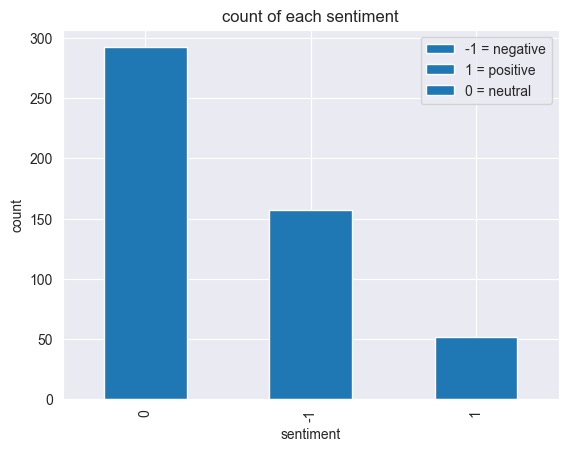

In [85]:
import matplotlib.patches as mpatches

tv_tropes_df['sentiment'].value_counts().plot(kind='bar', xlabel= 'sentiment', ylabel = 'count', title = 'count of each sentiment')
neg_patch = mpatches.Patch(label='-1 = negative')
pos_patch = mpatches.Patch(label='1 = positive')
neu_patch = mpatches.Patch(label='0 = neutral')
blue_patch = mpatches.Patch(color='blue', label='Positive')

plt.legend(handles=[neg_patch, pos_patch, neu_patch])

### 7) Plot analysis

Here we do some processing on the plot summaries for further use in Milestone 3.

In [86]:
# Load the plot summaries
plots_df = pd.read_csv('data/plot_summaries.txt', sep='	')

In [87]:
plots_df.head()

,Wikipedia movie ID,movie_plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [88]:
# Load the dataset of possible stopwords
with open('data/stopwords.pkl', 'rb') as f:
    stopwords = pickle.load(f)

In [89]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\diced\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

The preprocessing consists of tokenizing and stemming the plots words in order to be able to compute embeddings and thus similarities in Milestone3
- Tokenization: transform text into list of words
- Stemming: Reduce a word to its word stem that affixes to suffixes and prefixes or to the roots of words known as a lemma.


In [90]:
subpath = "../data/corenlp_plot_summaries/"
import xml.sax

def tokenize_and_stem(text, id):
    """
    Tokenize and stem the plots
    :param text: The plot's text
    :return: The List of stemmed words
    """

    def is_important_word(xml_dict):
        def ret(word):
            pass
        return ret

    words = word_tokenize(text)

    zip_name = id + ".xml.gz"
    file_name = id + ".txt.xml"


    with ZipFile(subpath + zip_name, 'r') as zip:
        zip.extractall(subpath)

    with open(subpath + file_name, 'r') as xmlfile:
        xmldict = xmltodict.parse(xmlfile.read())
        words = list(filter(is_important_word, words))
    os.remove(subpath + file_name)
    # Stem the filtered_tokens
    stems = [PorterStemmer().stem(t) for t in words]
    return stems

In [91]:
# Takes time 
plots_df['Tokens'] = plots_df['movie_plot'].apply(tokenize_and_stem)

In [92]:
# Example
print(plots_df['movie_plot'][0])
words_stemmed = tokenize_and_stem(plots_df['movie_plot'][0])
print(words_stemmed)

Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.
['shlykov', ',', 'a', 'hard-work', 'taxi', 'driver', 'and', 'lyosha', ',', 'a', 'saxophonist', ',', 'develop', 'a', 'bizarr', 'love-h', 'relationship', ',', 'and', 'despit', 'their', 'prejudic', ',', 'realiz', 'they', 'are', "n't", 'so', 'differ', 'after', 'all', '.']
